In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
#from PyEMD import EMD
from scipy.signal import hilbert, medfilt

from pathlib import Path
import re
from pprint import pprint

import numpy as np
from scipy import signal, ndimage
import matplotlib.pyplot as plt
from matplotlib import pyplot
import pandas as pd

import emd
import eelbrain
import mne

/Users/neuroling/anaconda3/envs/eelbrain/lib/python3.11/site-packages/eelbrain/mne_fixes/_interpolation.py:13: FutureWarning: mne.io.pick.pick_types is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
  from mne.io.pick import pick_types, pick_channels
/Users/neuroling/anaconda3/envs/eelbrain/lib/python3.11/site-packages/eelbrain/mne_fixes/_interpolation.py:13: FutureWarning: mne.io.pick.pick_channels is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
  from mne.io.pick import pick_types, pick_channels


In [4]:
### (OLD FUNCTION)
# ==========================================
# 2. HELPER FUNCTIONS
# ==========================================
def get_inst_freq_amp(signal, fs):
    """
    Calculates instantaneous amplitude (envelope) and frequency 
    using the Hilbert Transform.
    """
    analytic_signal = hilbert(signal)
    amplitude = np.abs(analytic_signal)
    instantaneous_phase = np.unwrap(np.angle(analytic_signal))
    
    # Calculate Instantaneous Frequency (derivative of phase)
    # factor of 1/(2*pi) converts rad/s to Hz
    inst_freq = np.diff(instantaneous_phase) / (2.0 * np.pi) * fs
    
    # Append last sample to match array length
    inst_freq = np.append(inst_freq, inst_freq[-1])
    
    return amplitude, inst_freq

def load_trf_data(filename):
    """
    Loads TRF data from pickle. Handles simplified data structures.
    """
    with open(filename, 'rb') as f:
        data = pickle.load(f)
    
    # LOGIC to handle different pickle structures:
    if isinstance(data, np.ndarray):
        trf = data
    elif isinstance(data, dict):
        # Checks for common keys, user might need to adjust this
        keys = [k for k in data.keys() if 'trf' in k.lower() or 'data' in k.lower()]
        if keys:
            trf = data[keys[0]]
            print(f"Loaded key '{keys[0]}' from dictionary.")
        else:
            raise ValueError(f"Could not find data in dictionary keys: {data.keys()}")
    else:
        raise ValueError("Pickle file must contain a numpy array or a dictionary.")

    # Ensure 1D array (if 2D, takes the first channel/dimension)
    if trf.ndim > 1:
        print(f"Data shape is {trf.shape}. Taking the first channel/vector.")
        trf = trf.flatten() if trf.shape[0] == 1 or trf.shape[1] == 1 else trf[0,:]
        
    return trf

# ==========================================
# 3. HHSA MAIN ALGORITHM
# ==========================================
def run_hhsa(signal, fs):
    """
    Performs Two-Layer EMD (Holo-Hilbert Spectral Analysis).
    """
    emd = EMD()
    emd.emd(signal)
    imfs_layer1 = emd.get_imfs_and_residue()[0]
    
    holo_points = [] # To store (Carrier_Freq, AM_Freq, Power) triplets

    print(f"Layer 1 Decomposition: Found {imfs_layer1.shape[0]} Carrier IMFs.")
    
    # --- LAYER 1 LOOP (Carrier Frequencies) ---
    for i, imf_c in enumerate(imfs_layer1):
        # 1. Get Carrier Envelope and Frequency
        env_c, freq_c = get_inst_freq_amp(imf_c, fs)
        
        # Filter negative/noise frequencies
        valid_mask_c = (freq_c > 0) & (freq_c < fs/2)
        
        # --- LAYER 2 LOOP (Amplitude Modulation) ---
        # Decompose the ENVELOPE of the carrier
        if np.sum(np.abs(env_c)) < 1e-10: continue # Skip empty IMFs
        
        try:
            imfs_layer2 = emd(env_c)
        except:
            continue # Skip if EMD fails on noise
            
        for j, imf_am in enumerate(imfs_layer2):
            # 2. Get AM Frequency
            _, freq_am = get_inst_freq_amp(imf_am, fs)
            
            # 3. Calculate Power (Instantaneous Energy)
            # Power is the square of the AM component amplitude
            power_am = imf_am**2
            
            # 4. Collect Triplet Points [fc, fam, power]
            # We iterate through time points to map instantaneous relationships
            mask_am = (freq_am > 0) & (freq_am < fs/2)
            combined_mask = valid_mask_c & mask_am
            
            # Add valid points to list
            # We downsample slightly if data is huge to save memory, or take all points
            idx = np.where(combined_mask)[0]
            
            if len(idx) > 0:
                # Stack: Col 0 = Carrier Freq, Col 1 = AM Freq, Col 2 = Power
                points = np.vstack((freq_c[idx], freq_am[idx], power_am[idx])).T
                holo_points.append(points)

    if not holo_points:
        return None

    # Concatenate all points from all modes
    return np.vstack(holo_points)

In [7]:
if __name__ == "__main__":

    ## ESLs ##
    #STIMULI = [str(i) for i in range(1, 13)]
    #DATA_ROOT = Path("/Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results")  #Path("~").expanduser() / 'Data' / 'Alice'
    DATA_ROOT = Path("/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results")
    #PREDICTOR_audio_DIR = DATA_ROOT / 'TRFs_pridictors/audio_predictors'
    #PREDICTOR_word_DIR = DATA_ROOT / 'TRFs_pridictors/word_predictors'
    EEG_DIR = DATA_ROOT / 'EEG_ESLs' / 'Alice_ESL_ICAed_fif'
    IMF_DIR = DATA_ROOT/ "TRFs_pridictors/IF_predictors"
    F0_DIR = DATA_ROOT/ "TRFs_pridictors/F0_predictors"
    IMFsLIST = [path.name for path in IMF_DIR.iterdir() if re.match(r'Alice_IF_IMF_*', path.name)] 
    ESL_SUBJECTS = [path.name for path in EEG_DIR.iterdir() if re.match(r'n_2_S\d*', path.name)]  #S01_alice-raw.fif
    
    # Define a target directory for TRF estimates and make sure the directory is created
    TRF_DIR = DATA_ROOT / 'TRFs_ESLs'
    TRF_DIR.mkdir(exist_ok=True)
    print(ESL_SUBJECTS)
    print(len(ESL_SUBJECTS))  # 26
    DST = TRF_DIR / 'ESLs_figures'
    DST.mkdir(exist_ok=True)

['n_2_S030_ICAed_raw.fif', 'n_2_S027_ICAed_raw.fif', 'n_2_S023_ICAed_raw.fif', 'n_2_S034_ICAed_raw.fif', 'n_2_S024_ICAed_raw.fif', 'n_2_S019_ICAed_raw.fif', 'n_2_S020_ICAed_raw.fif', 'n_2_S013_ICAed_raw.fif', 'n_2_S017_ICAed_raw.fif', 'n_2_S039_ICAed_raw.fif', 'n_2_S010_ICAed_raw.fif', 'n_2_S029_ICAed_raw.fif', 'n_2_S015_ICAed_raw.fif', 'n_2_S028_ICAed_raw.fif', 'n_2_S011_ICAed_raw.fif', 'n_2_S038_ICAed_raw.fif', 'n_2_S016_ICAed_raw.fif', 'n_2_S012_ICAed_raw.fif', 'n_2_S021_ICAed_raw.fif', 'n_2_S036_ICAed_raw.fif', 'n_2_S032_ICAed_raw.fif', 'n_2_S025_ICAed_raw.fif', 'n_2_S035_ICAed_raw.fif', 'n_2_S022_ICAed_raw.fif', 'n_2_S026_ICAed_raw.fif', 'n_2_S031_ICAed_raw.fif']
26


In [19]:
# Load in the TRF .pickle file (I choose F0 & En & EnOnset)

# Compare the TRFs corresponding to F0 and Envelopes.
# Build the model_data['model']
models = ['Fzero', 'Fzero+envelope', 'Fzero+envelope+env_onset'] # Change the description
rows = []
for model in models:
    print(model)
    for subject in ESL_SUBJECTS:
        trf = eelbrain.load.unpickle(TRF_DIR / subject[4:8] / f'{subject[4:8]} {model}.pickle')
        #print(trf)
        trf.x = ['f0', 'f0env', 'f0envenvon'] #rename the model (no punctuation)
        rows.append([subject, model, *trf.h_scaled])
        #rows.append([subject, model, *trf.h])
        #rows.append([subject, model, trf.proportion_explained])
model_data = eelbrain.Dataset.from_caselist(['subject', 'model', *trf.x], rows)
#model_data = eelbrain.Dataset.from_caselist(['subject', 'model', 'det'], rows)
#pprint(rows)
print(model_data)

Fzero
Fzero+envelope
Fzero+envelope+env_onset


ValueError: not all cases have same length

In [20]:
"""
import numpy as np
import matplotlib.pyplot as plt
import eelbrain
from pathlib import Path
import re
from PyEMD import EMD
from scipy.signal import hilbert
"""

# Version 1 of HHSA & TRF

# ==========================================
# 1. HHSA CORE FUNCTIONS
# ==========================================
def get_inst_freq_amp(signal, fs):
    """
    Calculates instantaneous amplitude (envelope) and frequency
    using the Hilbert Transform.
    """
    analytic_signal = hilbert(signal)
    amplitude = np.abs(analytic_signal)
    instantaneous_phase = np.unwrap(np.angle(analytic_signal))
    
    # Instantaneous Frequency (derivative of phase)
    inst_freq = np.diff(instantaneous_phase) / (2.0 * np.pi) * fs
    # Pad to match length
    inst_freq = np.append(inst_freq, inst_freq[-1])
    
    return amplitude, inst_freq

def run_hhsa(signal, fs):
    """
    Performs Two-Layer EMD (Holo-Hilbert Spectral Analysis).
    """
    # Standardize signal shape to 1D array
    if signal.ndim > 1: signal = signal.flatten()
    
    emd = EMD()
    # Layer 1: Carrier Decomposition
    try:
        imfs_layer1 = emd(signal)
    except:
        return None # Skip if EMD fails (e.g. signal too short/flat)
        
    holo_points = []
    
    for imf_c in imfs_layer1:
        # Layer 1 Analysis
        env_c, freq_c = get_inst_freq_amp(imf_c, fs)
        
        # Skip empty/flat IMFs
        if np.sum(np.abs(env_c)) < 1e-10: continue

        # Layer 2: Amplitude Modulation Decomposition
        try:
            imfs_layer2 = emd(env_c)
        except:
            continue
            
        for imf_am in imfs_layer2:
            # Layer 2 Analysis
            _, freq_am = get_inst_freq_amp(imf_am, fs)
            power_am = imf_am**2 # Energy
            
            # Filter for valid positive frequencies
            mask = (freq_c > 0) & (freq_c < fs/2) & (freq_am > 0) & (freq_am < fs/2)
            idx = np.where(mask)[0]
            
            if len(idx) > 0:
                # Store [Carrier_Freq, AM_Freq, Power]
                points = np.vstack((freq_c[idx], freq_am[idx], power_am[idx])).T
                holo_points.append(points)
                
    if not holo_points: return None
    return np.vstack(holo_points)

# ==========================================
# 2. YOUR EXPERIMENT SETUP
# ==========================================

# -- Path Configuration --
DATA_ROOT = Path("/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results")
EEG_DIR = DATA_ROOT / 'EEG_ESLs' / 'Alice_ESL_ICAed_fif'
TRF_DIR = DATA_ROOT / 'TRFs_ESLs'

# -- Subject List --
# Extracts subject IDs from filenames like 'n_2_S01...'
ESL_SUBJECTS = [path.name for path in EEG_DIR.iterdir() if re.match(r'n_2_S\d*', path.name)]
print(f"Found {len(ESL_SUBJECTS)} subjects.")

# -- Analysis Configuration --
TARGET_MODEL = 'Fzero+envelope'  # Which .pickle file to load
TARGET_PREDICTOR = 'envelope'    # Which part of the TRF to analyze ('envelope', 'f0', etc.)
LIMIT_CARRIER = 40 # Hz (Max X-axis frequency to plot)
LIMIT_AM = 20      # Hz (Max Y-axis frequency to plot)
NBINS = 100        # Resolution of the heatmap

# -- Group Accumulators --
group_spectrum_sum = None
n_subjects_processed = 0

# ==========================================
# 3. MAIN LOOP: LOAD -> HHSA -> ACCUMULATE
# ==========================================

print(f"Starting Group HHSA on Model: {TARGET_MODEL} | Predictor: {TARGET_PREDICTOR}")

for subject in ESL_SUBJECTS:
    subject_id_short = subject[4:8] # e.g., 'S01_'
    # Construct file path: TRF_DIR / S01_ / S01_ Fzero+envelope.pickle
    file_path = TRF_DIR / subject_id_short / f'{subject_id_short} {TARGET_MODEL}.pickle'
    
    if not file_path.exists():
        print(f"  [Skipped] File not found: {file_path}")
        continue

    try:
        # A. LOAD EELBRAIN OBJECT
        trf_obj = eelbrain.load.unpickle(file_path)
        
        # B. EXTRACT TRF VECTOR
        # 1. Determine which variable holds the data (.h or .h_scaled)
        if hasattr(trf_obj, 'h_scaled'):
            data_ndvar = trf_obj.h_scaled
        else:
            data_ndvar = trf_obj.h
            
        # 2. Select Predictor and Average Sensors
        #    Check if predictor exists in this model
        if TARGET_PREDICTOR in data_ndvar.xnames:
            # Extract just the target predictor and average over sensors
            trf_ndvar = data_ndvar.sub(name=TARGET_PREDICTOR).mean('sensor')
        else:
            print(f"  [Skipped] Predictor '{TARGET_PREDICTOR}' not found in {subject}")
            continue

        # 3. Get Raw Vector and Sampling Rate
        trf_vector = trf_ndvar.x
        fs = 1.0 / trf_ndvar.time.tstep
        
        # C. RUN HHSA
        # print(f"  Processing {subject_id_short}...")
        holo_data = run_hhsa(trf_vector, fs)
        
        if holo_data is None: 
            print(f"  [Warning] No valid HHSA modes for {subject_id_short}")
            continue

        # D. BIN INTO HEATMAP (for Group Average)
        fc = holo_data[:, 0]
        fam = holo_data[:, 1]
        power = holo_data[:, 2]
        
        # Create 2D Histogram for this subject
        H_subj, xedges, yedges = np.histogram2d(fc, fam, bins=NBINS, weights=power,
                                           range=[[0, LIMIT_CARRIER], [0, LIMIT_AM]])
        
        # Add to Group Sum
        if group_spectrum_sum is None:
            group_spectrum_sum = H_subj
        else:
            group_spectrum_sum += H_subj
            
        n_subjects_processed += 1
        
    except Exception as e:
        print(f"  [Error] Failed on {subject}: {e}")
        continue

# ==========================================
# 4. PLOT GRAND AVERAGE
# ==========================================
if n_subjects_processed > 0:
    # Compute Mean
    group_avg_spectrum = group_spectrum_sum / n_subjects_processed
    
    # Plot
    plt.figure(figsize=(10, 8))
    # Note: .T (transpose) is usually needed because histogram2d returns x,y but imshow expects row,col
    plt.imshow(group_avg_spectrum.T, origin='lower', cmap='jet', aspect='auto',
               extent=[0, LIMIT_CARRIER, 0, LIMIT_AM], interpolation='gaussian')
    
    plt.colorbar(label='Modulation Power (a.u.)')
    plt.xlabel('Carrier Frequency (Hz)')
    plt.ylabel('AM Frequency (Hz)')
    plt.title(f'Group HHSA: {TARGET_MODEL} [{TARGET_PREDICTOR}] (N={n_subjects_processed})')
    
    # Add diagonal line (where AM freq == Carrier freq)
    plt.plot([0, LIMIT_AM], [0, LIMIT_AM], 'w--', alpha=0.5)
    
    plt.show()
    print("Group Analysis Complete.")
else:
    print("No subjects were successfully processed.")

Found 26 subjects.
Starting Group HHSA on Model: Fzero+envelope | Predictor: envelope
  [Error] Failed on n_2_S030_ICAed_raw.fif: 'tuple' object has no attribute 'xnames'
  [Error] Failed on n_2_S027_ICAed_raw.fif: 'tuple' object has no attribute 'xnames'
  [Error] Failed on n_2_S023_ICAed_raw.fif: 'tuple' object has no attribute 'xnames'
  [Error] Failed on n_2_S034_ICAed_raw.fif: 'tuple' object has no attribute 'xnames'
  [Error] Failed on n_2_S024_ICAed_raw.fif: 'tuple' object has no attribute 'xnames'
  [Error] Failed on n_2_S019_ICAed_raw.fif: 'tuple' object has no attribute 'xnames'
  [Error] Failed on n_2_S020_ICAed_raw.fif: 'tuple' object has no attribute 'xnames'
  [Error] Failed on n_2_S013_ICAed_raw.fif: 'tuple' object has no attribute 'xnames'
  [Error] Failed on n_2_S017_ICAed_raw.fif: 'tuple' object has no attribute 'xnames'
  [Error] Failed on n_2_S039_ICAed_raw.fif: 'tuple' object has no attribute 'xnames'
  [Error] Failed on n_2_S010_ICAed_raw.fif: 'tuple' object has n

In [29]:
"""
import numpy as np
import matplotlib.pyplot as plt
import eelbrain
from pathlib import Path
import re
from PyEMD import EMD
from scipy.signal import hilbert
"""
# Version 2 of HHSA & TRF

# ==========================================
# 1. HHSA CORE FUNCTIONS (Keep this part)
# ==========================================
def get_inst_freq_amp(signal, fs):
    analytic_signal = hilbert(signal)
    amplitude = np.abs(analytic_signal)
    instantaneous_phase = np.unwrap(np.angle(analytic_signal))
    inst_freq = np.diff(instantaneous_phase) / (2.0 * np.pi) * fs
    inst_freq = np.append(inst_freq, inst_freq[-1])
    return amplitude, inst_freq

def run_hhsa(signal, fs):
    if signal.ndim > 1: signal = signal.flatten()
    emd = EMD()
    try:
        imfs_layer1 = emd(signal)
    except:
        return None
        
    holo_points = []
    for imf_c in imfs_layer1:
        env_c, freq_c = get_inst_freq_amp(imf_c, fs)
        if np.sum(np.abs(env_c)) < 1e-10: continue
        try:
            imfs_layer2 = emd(env_c)
        except:
            continue  
        for imf_am in imfs_layer2:
            _, freq_am = get_inst_freq_amp(imf_am, fs)
            power_am = imf_am**2
            mask = (freq_c > 0) & (freq_c < fs/2) & (freq_am > 0) & (freq_am < fs/2)
            idx = np.where(mask)[0]
            if len(idx) > 0:
                points = np.vstack((freq_c[idx], freq_am[idx], power_am[idx])).T
                holo_points.append(points)
    if not holo_points: return None
    return np.vstack(holo_points)

# ==========================================
# 2. YOUR EXPERIMENT SETUP
# ==========================================
DATA_ROOT = Path("/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results")
EEG_DIR = DATA_ROOT / 'EEG_ESLs' / 'Alice_ESL_ICAed_fif'
TRF_DIR = DATA_ROOT / 'TRFs_ESLs'

# Extract subject IDs
ESL_SUBJECTS = [path.name for path in EEG_DIR.iterdir() if re.match(r'n_2_S\d*', path.name)]
print(f"Found {len(ESL_SUBJECTS)} subjects.")
print(ESL_SUBJECTS)

# Settings
TARGET_MODEL = 'envelope' #'Fzero+envelope'
TARGET_PREDICTOR = 'envelope'
LIMIT_CARRIER = 30 
LIMIT_AM = 15      
NBINS = 100        

group_spectrum_sum = None
n_subjects_processed = 0

# ==========================================
# 3. MAIN LOOP (With FIX for Tuple Error)
# ==========================================
print(f"Starting Group HHSA on Model: {TARGET_MODEL} | Predictor: {TARGET_PREDICTOR}")

for subject in ESL_SUBJECTS:
    subject_id_short = subject[4:8] # Extract 'S030' from filename
    file_path = TRF_DIR / subject_id_short / f'{subject_id_short} {TARGET_MODEL}.pickle'
    
    if not file_path.exists():
        print(f"  [Skipped] File not found: {file_path}")
        continue

    try:
        trf_obj = eelbrain.load.unpickle(file_path)
        
        # 1. Get the Data Object (Check h_scaled vs h)
        if hasattr(trf_obj, 'h_scaled'):
            data_ndvar = trf_obj.h_scaled
        else:
            data_ndvar = trf_obj.h

        # --- FIX STARTS HERE ---
        # If the result is a tuple (e.g. multiple partitions), take the first one.
        if isinstance(data_ndvar, tuple):
            # print(f"  [Info] Unpacking tuple for {subject_id_short}...")
            data_ndvar = data_ndvar[0]
        # --- FIX ENDS HERE ---

        # 2. Select Predictor and Average Sensors
        if hasattr(data_ndvar, 'xnames'):
            if TARGET_PREDICTOR in data_ndvar.xnames:
                # Extract predictor and average across sensors
                trf_ndvar = data_ndvar.sub(name=TARGET_PREDICTOR).mean('sensor')
            else:
                print(f"  [Skipped] '{TARGET_PREDICTOR}' not in {data_ndvar.xnames}")
                continue
        else:
            print(f"  [Error] Object is still not an NDVar: {type(data_ndvar)}")
            continue

        # 3. Get Vector and Fs
        trf_vector = trf_ndvar.x
        fs = 1.0 / trf_ndvar.time.tstep
        
        # 4. Run HHSA
        holo_data = run_hhsa(trf_vector, fs)
        
        if holo_data is None: 
            # print(f"  [Warning] No valid HHSA modes for {subject_id_short}")
            continue

        # 5. Bin Data
        fc = holo_data[:, 0]
        fam = holo_data[:, 1]
        power = holo_data[:, 2]
        H_subj, xedges, yedges = np.histogram2d(fc, fam, bins=NBINS, weights=power,
                                           range=[[0, LIMIT_CARRIER], [0, LIMIT_AM]])
        
        if group_spectrum_sum is None:
            group_spectrum_sum = H_subj
        else:
            group_spectrum_sum += H_subj
            
        n_subjects_processed += 1
        
    except Exception as e:
        print(f"  [Error] Failed on {subject}: {e}")
        continue

# ==========================================
# 4. PLOT GRAND AVERAGE
# ==========================================
if n_subjects_processed > 0:
    group_avg_spectrum = group_spectrum_sum / n_subjects_processed
    
    plt.figure(figsize=(10, 8))
    plt.imshow(group_avg_spectrum.T, origin='lower', cmap='jet', aspect='auto',
               extent=[0, LIMIT_CARRIER, 0, LIMIT_AM], interpolation='gaussian')
    plt.colorbar(label='Modulation Power (a.u.)')
    plt.xlabel('Carrier Frequency (Hz)')
    plt.ylabel('AM Frequency (Hz)')
    plt.title(f'Group HHSA: {TARGET_MODEL} [{TARGET_PREDICTOR}] (N={n_subjects_processed})')
    plt.plot([0, LIMIT_AM], [0, LIMIT_AM], 'w--', alpha=0.5)
    plt.show()
    print("Group Analysis Complete.")
else:
    print("No subjects were successfully processed.")

Found 26 subjects.
['n_2_S030_ICAed_raw.fif', 'n_2_S027_ICAed_raw.fif', 'n_2_S023_ICAed_raw.fif', 'n_2_S034_ICAed_raw.fif', 'n_2_S024_ICAed_raw.fif', 'n_2_S019_ICAed_raw.fif', 'n_2_S020_ICAed_raw.fif', 'n_2_S013_ICAed_raw.fif', 'n_2_S017_ICAed_raw.fif', 'n_2_S039_ICAed_raw.fif', 'n_2_S010_ICAed_raw.fif', 'n_2_S029_ICAed_raw.fif', 'n_2_S015_ICAed_raw.fif', 'n_2_S028_ICAed_raw.fif', 'n_2_S011_ICAed_raw.fif', 'n_2_S038_ICAed_raw.fif', 'n_2_S016_ICAed_raw.fif', 'n_2_S012_ICAed_raw.fif', 'n_2_S021_ICAed_raw.fif', 'n_2_S036_ICAed_raw.fif', 'n_2_S032_ICAed_raw.fif', 'n_2_S025_ICAed_raw.fif', 'n_2_S035_ICAed_raw.fif', 'n_2_S022_ICAed_raw.fif', 'n_2_S026_ICAed_raw.fif', 'n_2_S031_ICAed_raw.fif']
Starting Group HHSA on Model: envelope | Predictor: envelope
  [Error] Object is still not an NDVar: <class 'eelbrain._data_obj.NDVar'>
  [Error] Object is still not an NDVar: <class 'eelbrain._data_obj.NDVar'>
  [Error] Object is still not an NDVar: <class 'eelbrain._data_obj.NDVar'>
  [Error] Object i

In [31]:
"""
import numpy as np
import matplotlib.pyplot as plt
import eelbrain
from pathlib import Path
import re
from PyEMD import EMD
from scipy.signal import hilbert
"""

# Version 3 of HHSA & TRF

# ==========================================
# 1. HHSA CORE FUNCTIONS (Unchanged)
# ==========================================
def get_inst_freq_amp(signal, fs):
    analytic_signal = hilbert(signal)
    amplitude = np.abs(analytic_signal)
    instantaneous_phase = np.unwrap(np.angle(analytic_signal))
    inst_freq = np.diff(instantaneous_phase) / (2.0 * np.pi) * fs
    inst_freq = np.append(inst_freq, inst_freq[-1])
    return amplitude, inst_freq

def run_hhsa(signal, fs):
    if signal.ndim > 1: signal = signal.flatten()
    emd = EMD()
    try:
        imfs_layer1 = emd(signal)
    except:
        return None
        
    holo_points = []
    for imf_c in imfs_layer1:
        env_c, freq_c = get_inst_freq_amp(imf_c, fs)
        if np.sum(np.abs(env_c)) < 1e-10: continue
        try:
            imfs_layer2 = emd(env_c)
        except:
            continue
        for imf_am in imfs_layer2:
            _, freq_am = get_inst_freq_amp(imf_am, fs)
            power_am = imf_am**2
            mask = (freq_c > 0) & (freq_c < fs/2) & (freq_am > 0) & (freq_am < fs/2)
            idx = np.where(mask)[0]
            if len(idx) > 0:
                points = np.vstack((freq_c[idx], freq_am[idx], power_am[idx])).T
                holo_points.append(points)
    if not holo_points: return None
    return np.vstack(holo_points)

# ==========================================
# 2. SETUP
# ==========================================
DATA_ROOT = Path("/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results")
EEG_DIR = DATA_ROOT / 'EEG_ESLs' / 'Alice_ESL_ICAed_fif'
TRF_DIR = DATA_ROOT / 'TRFs_ESLs'

ESL_SUBJECTS = [path.name for path in EEG_DIR.iterdir() if re.match(r'n_2_S\d*', path.name)]
print(f"Found {len(ESL_SUBJECTS)} subjects.")

# Settings
TARGET_MODEL = 'envelope'#'Fzero+envelope'
TARGET_PREDICTOR = 'envelope'
LIMIT_CARRIER = 30 
LIMIT_AM = 15      
NBINS = 100        

group_spectrum_sum = None
n_subjects_processed = 0

# ==========================================
# 3. MAIN LOOP (Fixed Extraction Logic)
# ==========================================
print(f"Starting Group HHSA on Model: {TARGET_MODEL} | Predictor: {TARGET_PREDICTOR}")

for subject in ESL_SUBJECTS:
    subject_id_short = subject[4:8] # Extract 'S030'
    file_path = TRF_DIR / subject_id_short / f'{subject_id_short} {TARGET_MODEL}.pickle'
    
    if not file_path.exists():
        print(f"  [Skipped] File not found: {file_path}")
        continue

    try:
        trf_obj = eelbrain.load.unpickle(file_path)
        
        # 1. Get the NDVar
        if hasattr(trf_obj, 'h_scaled'):
            data_ndvar = trf_obj.h_scaled
        else:
            data_ndvar = trf_obj.h
            
        # Unpack tuple if necessary
        if isinstance(data_ndvar, tuple):
            data_ndvar = data_ndvar[0]
            
        # 2. Select Predictor and Average Sensors
        # FIX: Directly attempt to access the predictor instead of checking xnames
        try:
            # Try 1: Direct indexing (Standard for NDVar with categorical dimension)
            trf_predictor = data_ndvar[TARGET_PREDICTOR]
        except:
            try:
                # Try 2: Maybe it's called 'f0env' like in your previous code?
                # If TARGET_PREDICTOR fails, try a fallback or print available keys
                # print(f"  [Info] Keys found: {data_ndvar.keys()}")
                trf_predictor = data_ndvar['f0env'] # Fallback based on your snippet
            except:
                # print(f"  [Skipped] Could not find '{TARGET_PREDICTOR}' in {subject_id_short}")
                continue

        # Average across sensors (if sensor dimension exists)
        if 'sensor' in trf_predictor.dimnames:
            trf_final = trf_predictor.mean('sensor')
        else:
            trf_final = trf_predictor

        # 3. Get Data and Fs
        trf_vector = trf_final.x
        fs = 1.0 / trf_final.time.tstep
        
        # 4. Run HHSA
        holo_data = run_hhsa(trf_vector, fs)
        
        if holo_data is None: continue

        # 5. Bin Data
        fc = holo_data[:, 0]
        fam = holo_data[:, 1]
        power = holo_data[:, 2]
        H_subj, xedges, yedges = np.histogram2d(fc, fam, bins=NBINS, weights=power,
                                           range=[[0, LIMIT_CARRIER], [0, LIMIT_AM]])
        
        if group_spectrum_sum is None:
            group_spectrum_sum = H_subj
        else:
            group_spectrum_sum += H_subj
            
        n_subjects_processed += 1
        
    except Exception as e:
        print(f"  [Error] Failed on {subject}: {e}")
        continue

# ==========================================
# 4. PLOT GRAND AVERAGE
# ==========================================
if n_subjects_processed > 0:
    group_avg_spectrum = group_spectrum_sum / n_subjects_processed
    
    plt.figure(figsize=(10, 8))
    plt.imshow(group_avg_spectrum.T, origin='lower', cmap='jet', aspect='auto',
               extent=[0, LIMIT_CARRIER, 0, LIMIT_AM], interpolation='gaussian')
    plt.colorbar(label='Modulation Power (a.u.)')
    plt.xlabel('Carrier Frequency (Hz)')
    plt.ylabel('AM Frequency (Hz)')
    plt.title(f'Group HHSA: {TARGET_MODEL} [{TARGET_PREDICTOR}] (N={n_subjects_processed})')
    plt.plot([0, LIMIT_AM], [0, LIMIT_AM], 'w--', alpha=0.5)
    
    plt.show()
    print("Group Analysis Complete.")
else:
    print("No subjects were successfully processed.")

Found 26 subjects.
Starting Group HHSA on Model: envelope | Predictor: envelope
No subjects were successfully processed.


In [32]:
#import eelbrain
#from pathlib import Path

# --- CONFIGURATION ---
# Use the same paths as before
DATA_ROOT = Path("/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results")
TRF_DIR = DATA_ROOT / 'TRFs_ESLs'
TARGET_MODEL = 'Fzero+envelope' 

# Pick one subject ID that you know exists (e.g., S01)
TEST_SUBJECT = 'S010'  
#Original path: /Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/TRFs_ESLs/S010/S010 Fzero+envelope.pickle

print(f"--- DIAGNOSTIC FOR {TEST_SUBJECT} ---")
file_path = TRF_DIR / TEST_SUBJECT / f'{TEST_SUBJECT} {TARGET_MODEL}.pickle'

if file_path.exists():
    try:
        # 1. Load the object
        trf_obj = eelbrain.load.unpickle(file_path)
        print(f"1. Object Type: {type(trf_obj)}")
        
        # 2. Inspect attributes
        print(f"2. Attributes: {dir(trf_obj)}")
        
        # 3. Check for 'h' or 'h_scaled'
        if hasattr(trf_obj, 'h_scaled'):
            data = trf_obj.h_scaled
            print("3. Found 'h_scaled'")
        elif hasattr(trf_obj, 'h'):
            data = trf_obj.h
            print("3. Found 'h'")
        else:
            print("3. NO 'h' or 'h_scaled' found!")
            data = None
            
        # 4. If data exists, inspect dimensions
        if data is not None:
            # Handle tuple case
            if isinstance(data, tuple):
                print("   (Data is a tuple, taking first element)")
                data = data[0]
                
            print(f"4. Data Type: {type(data)}")
            
            if hasattr(data, 'dimnames'):
                print(f"5. Dimensions: {data.dimnames}")
            
            if hasattr(data, 'x'):
                print(f"6. Shape of .x: {data.x.shape}")
                
            # Check for categorical keys (Predictor names)
            # Try to print the keys of the first dimension
            try:
                first_dim = data.get_dim(data.dimnames[0])
                print(f"7. Keys in first dimension ('{data.dimnames[0]}'): {first_dim.values}")
            except:
                print("7. Could not read keys of first dimension.")

    except Exception as e:
        print(f"CRITICAL ERROR: {e}")
else:
    print(f"File not found: {file_path}")

--- DIAGNOSTIC FOR S010 ---
/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/TRFs_ESLs/S010/S010 Fzero+envelope.pickle
1. Object Type: <class 'eelbrain._trf._boosting.BoostingResult'>
2. Attributes: ['__annotations__', '__class__', '__dataclass_fields__', '__dataclass_params__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__match_args__', '__module__', '__ne__', '__new__', '__post_init__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_apply_ndvar_transform', '_eelbrain_concatenate', '_h', '_isnan', '_morph', '_set_connectivity', '_set_parc', '_variability', '_x_mean_array', '_x_scale_array', '_y_dims', '_y_info', 'algorithm_version', 'basis', 'basis_window', 'cross_predict', 'delta', 'error', 'fit', 'h', 'h_scaled', 'h_source', 

Found 26 subjects.
Starting Group HHSA on Model: Fzero


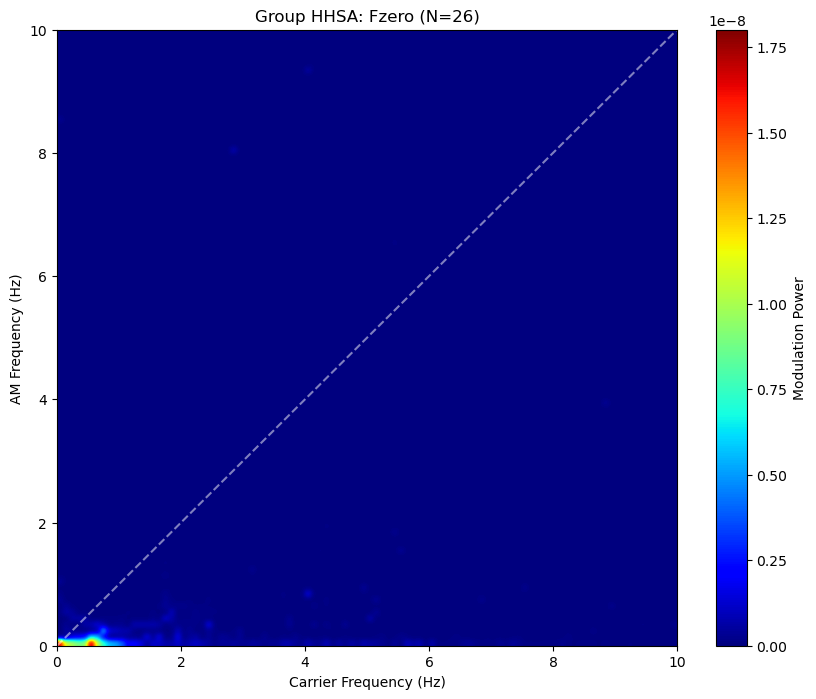

In [50]:
"""
import numpy as np
import matplotlib.pyplot as plt
import eelbrain
from pathlib import Path
import re
from PyEMD import EMD
from scipy.signal import hilbert
"""
# version 4 of HHSA & TRF

# ==========================================
# 1. HHSA CORE FUNCTIONS
# ==========================================
def get_inst_freq_amp(signal, fs):
    analytic_signal = hilbert(signal)
    amplitude = np.abs(analytic_signal)
    instantaneous_phase = np.unwrap(np.angle(analytic_signal))
    inst_freq = np.diff(instantaneous_phase) / (2.0 * np.pi) * fs
    inst_freq = np.append(inst_freq, inst_freq[-1])
    return amplitude, inst_freq

# Version 3 of the hhsa
#import numpy as np
#import emd # Ensure you have: pip install EMD-signal

def run_hhsa(signal, fs):
    # 1. Standardize input
    if signal.ndim > 1: signal = signal.flatten()
    
    n_samples = len(signal)
    
    # 2. Safety Check: If signal is extremely short, skip it
    if n_samples < 20: 
        return None

    # 3. MIRROR PADDING (The Fix)
    # We add 114 points to the left and 114 to the right. 
    # New length = 342, which is enough for EMD to run without crashing.
    pad_width = n_samples  
    padded_signal = np.pad(signal, pad_width, mode='reflect')
    
    # 4. Run Sift on PADDED signal
    # We lower max_imfs to 5, which is realistic for TRF data.
    try:
        imfs_layer1 = emd.sift.sift(padded_signal, max_imfs=5)
        # Transpose to shape (N_IMFs, N_Samples)
        imfs_layer1 = imfs_layer1.T 
    except Exception:
        return None

    holo_points = []
    
    # Layer 1 Loop (Carrier)
    for imf_c in imfs_layer1:
        # A. Un-pad: Extract the center part (the real data)
        imf_c_real = imf_c[pad_width : pad_width + n_samples]
        
        # B. Get Frequency & Envelope of the REAL section
        env_c, freq_c = get_inst_freq_amp(imf_c_real, fs)
        
        if np.sum(np.abs(env_c)) < 1e-10: continue

        # Layer 2 Loop (Amplitude Modulation)
        # We pad the ENVELOPE too, because it is also 114 points long
        padded_env = np.pad(env_c, pad_width, mode='reflect')
        
        try:
            imfs_layer2 = emd.sift.sift(padded_env, max_imfs=5)
            imfs_layer2 = imfs_layer2.T
        except:
            continue
            
        for imf_am in imfs_layer2:
            # Un-pad the AM result
            imf_am_real = imf_am[pad_width : pad_width + n_samples]
            
            _, freq_am = get_inst_freq_amp(imf_am_real, fs)
            power_am = imf_am_real**2
            
            # Filter valid frequencies
            mask = (freq_c > 0) & (freq_c < fs/2) & (freq_am > 0) & (freq_am < fs/2)
            idx = np.where(mask)[0]
            
            if len(idx) > 0:
                points = np.vstack((freq_c[idx], freq_am[idx], power_am[idx])).T
                holo_points.append(points)
                
    if not holo_points: return None
    return np.vstack(holo_points)

"""
# Version 2 of the hhsa
# --- UPDATE IMPORTS ---
#import emd  # The library you linked
# from PyEMD import EMD  <-- DELETE THIS LINE

def run_hhsa(signal, fs):
    # Ensure 1D array
    if signal.ndim > 1: signal = signal.flatten()
    
    # --- CHANGE 1: Use emd.sift.sift instead of EMD() ---
    try:
        # The 'max_imfs' argument is optional but helps speed up if data is noisy
        imfs_layer1 = emd.sift.sift(signal, max_imfs=10)
        
        # --- CHANGE 2: Transpose (.T) to match (N_IMFs, N_Samples) format ---
        imfs_layer1 = imfs_layer1.T
    except Exception as e:
        # print(f"Sifting failed: {e}")
        return None
        
    holo_points = []
    
    # Layer 1 (Carrier)
    for imf_c in imfs_layer1:
        env_c, freq_c = get_inst_freq_amp(imf_c, fs)
        if np.sum(np.abs(env_c)) < 1e-10: continue

        # Layer 2 (Amplitude Modulation)
        try:
            # Sift the envelope
            imfs_layer2 = emd.sift.sift(env_c, max_imfs=10)
            imfs_layer2 = imfs_layer2.T  # Transpose again
        except:
            continue
            
        for imf_am in imfs_layer2:
            _, freq_am = get_inst_freq_amp(imf_am, fs)
            power_am = imf_am**2
            
            # Filter valid frequencies
            mask = (freq_c > 0) & (freq_c < fs/2) & (freq_am > 0) & (freq_am < fs/2)
            idx = np.where(mask)[0]
            
            if len(idx) > 0:
                points = np.vstack((freq_c[idx], freq_am[idx], power_am[idx])).T
                holo_points.append(points)
                
    if not holo_points: return None
    return np.vstack(holo_points)
"""
    
"""
# The code if you are using PyEMD #
def run_hhsa(signal, fs):
    # Ensure 1D array
    if signal.ndim > 1: signal = signal.flatten()
    
    #emd = EMD()
    try:
        imfs_layer1 = emd(signal)
    except:
        return None
        
    holo_points = []
    
    # Layer 1 (Carrier)
    for imf_c in imfs_layer1:
        env_c, freq_c = get_inst_freq_amp(imf_c, fs)
        if np.sum(np.abs(env_c)) < 1e-10: continue

        # Layer 2 (Amplitude Modulation)
        try:
            imfs_layer2 = emd(env_c)
        except:
            continue
            
        for imf_am in imfs_layer2:
            _, freq_am = get_inst_freq_amp(imf_am, fs)
            power_am = imf_am**2
            
            # Filter valid frequencies
            mask = (freq_c > 0) & (freq_c < fs/2) & (freq_am > 0) & (freq_am < fs/2)
            idx = np.where(mask)[0]
            
            if len(idx) > 0:
                points = np.vstack((freq_c[idx], freq_am[idx], power_am[idx])).T
                holo_points.append(points)
                
    if not holo_points: return None
    return np.vstack(holo_points)
"""

# ==========================================
# 2. EXPERIMENT SETUP
# ==========================================
DATA_ROOT = Path("/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results")
EEG_DIR = DATA_ROOT / 'EEG_ESLs' / 'Alice_ESL_ICAed_fif'
TRF_DIR = DATA_ROOT / 'TRFs_ESLs'

# Get Subject List
ESL_SUBJECTS = [path.name for path in EEG_DIR.iterdir() if re.match(r'n_2_S\d*', path.name)]
print(f"Found {len(ESL_SUBJECTS)} subjects.")

# Analysis Settings
TARGET_MODEL = 'Fzero' #+envelope+env_onset'
LIMIT_CARRIER = 10  # Hz
LIMIT_AM = 10       # Hz
NBINS = 100

group_spectrum_sum = None
n_subjects_processed = 0

# ==========================================
# 3. MAIN PROCESSING LOOP
# ==========================================
print(f"Starting Group HHSA on Model: {TARGET_MODEL}")

for subject in ESL_SUBJECTS:
    subject_id_short = subject[4:8] # e.g., 'S010'
    file_path = TRF_DIR / subject_id_short / f'{subject_id_short} {TARGET_MODEL}.pickle'
    
    if not file_path.exists():
        continue

    try:
        # A. LOAD DATA
        trf_obj = eelbrain.load.unpickle(file_path)
        
        # Get the NDVar (Handle 'h_scaled' or 'h')
        if hasattr(trf_obj, 'h_scaled'):
            data_ndvar = trf_obj.h_scaled
        else:
            data_ndvar = trf_obj.h

        # Handle Tuple (Partitioned results)
        if isinstance(data_ndvar, tuple):
            data_ndvar = data_ndvar[0]

        # B. SELECT PREDICTOR (F0 vs Envelope)
        # We need to find which dimension contains the predictors.
        # Usually dims are ('time',) or ('sensor', 'time') or ('predictor', 'sensor', 'time')
        
        trf_final = None
        
        # Strategy 1: Attempt to grab 'envelope' by name if possible
        try:
            # If the object works like a dict (Categorical Dimension)
            trf_final = data_ndvar['envelope']
        except:
            # Strategy 2: Grab by Index
            # If Strategy 1 fails, we assume the structure is [F0, Envelope]
            # so Envelope is at index 1.
            # We look for the dimension that is NOT 'time' and NOT 'sensor'
            dims = data_ndvar.dimnames
            non_time_dims = [d for d in dims if d != 'time' and d != 'sensor']
            
            if len(non_time_dims) > 0:
                predictor_dim_name = non_time_dims[0]
                # print(f"  [Info] Assuming predictors are in dim: {predictor_dim_name}")
                
                # Take the 2nd item (Index 1) which is usually Envelope in 'F0+envelope'
                # If you want F0, change 1 to 0.
                trf_final = data_ndvar.sub(**{predictor_dim_name: 1}) 
            else:
                # If no predictor dimension, maybe it's already just the envelope?
                trf_final = data_ndvar

        # C. AVERAGE SENSORS & EXTRACT VECTOR
        if 'sensor' in trf_final.dimnames:
            trf_final = trf_final.mean('sensor')
            
        trf_vector = trf_final.x
        fs = 1.0 / trf_final.time.tstep
        
        # D. RUN HHSA
        # print(f"  Processing {subject_id_short}...")
        holo_data = run_hhsa(trf_vector, fs)
        
        if holo_data is None: continue

        # E. BIN DATA (Create Image)
        fc = holo_data[:, 0]
        fam = holo_data[:, 1]
        power = holo_data[:, 2]
        
        H_subj, xedges, yedges = np.histogram2d(fc, fam, bins=NBINS, weights=power,
                                           range=[[0, LIMIT_CARRIER], [0, LIMIT_AM]])
        
        if group_spectrum_sum is None:
            group_spectrum_sum = H_subj
        else:
            group_spectrum_sum += H_subj
            
        n_subjects_processed += 1
        
    except Exception as e:
        print(f"  [Error] Failed on {subject_id_short}: {e}")
        continue

# ==========================================
# 4. PLOT
# ==========================================
if n_subjects_processed > 0:
    group_avg_spectrum = group_spectrum_sum / n_subjects_processed
    
    plt.figure(figsize=(10, 8))
    plt.imshow(group_avg_spectrum.T, origin='lower', cmap='jet', aspect='auto',
               extent=[0, LIMIT_CARRIER, 0, LIMIT_AM], interpolation='gaussian')
    plt.colorbar(label='Modulation Power')
    plt.xlabel('Carrier Frequency (Hz)')
    plt.ylabel('AM Frequency (Hz)')
    plt.title(f'Group HHSA: {TARGET_MODEL} (N={n_subjects_processed})')
    plt.plot([0, LIMIT_AM], [0, LIMIT_AM], 'w--', alpha=0.5)
    plt.show()
else:
    print("No subjects processed. Check paths and pickle content.")

Found 26 subjects.
Starting Group HHSA on Model: Fzero+envelope
  Subject S030: Avg Carrier=4.81Hz, Avg AM=5.75Hz
  Subject S027: Avg Carrier=5.95Hz, Avg AM=5.26Hz
  Subject S023: Avg Carrier=4.72Hz, Avg AM=5.91Hz
  Subject S034: Avg Carrier=5.49Hz, Avg AM=5.57Hz
  Subject S024: Avg Carrier=5.31Hz, Avg AM=6.79Hz
  Subject S019: Avg Carrier=6.52Hz, Avg AM=4.32Hz
  Subject S020: Avg Carrier=7.73Hz, Avg AM=5.88Hz
  Subject S013: Avg Carrier=6.66Hz, Avg AM=5.78Hz
  Subject S017: Avg Carrier=5.58Hz, Avg AM=4.93Hz
  Subject S039: Avg Carrier=5.88Hz, Avg AM=6.57Hz
  Subject S010: Avg Carrier=4.87Hz, Avg AM=4.40Hz
  Subject S029: Avg Carrier=6.63Hz, Avg AM=7.38Hz
  Subject S015: Avg Carrier=4.46Hz, Avg AM=6.32Hz
  Subject S028: Avg Carrier=6.48Hz, Avg AM=5.23Hz
  Subject S011: Avg Carrier=6.19Hz, Avg AM=6.81Hz
  Subject S038: Avg Carrier=3.80Hz, Avg AM=6.41Hz
  Subject S016: Avg Carrier=6.33Hz, Avg AM=6.39Hz
  Subject S012: Avg Carrier=6.96Hz, Avg AM=5.81Hz
  Subject S021: Avg Carrier=6.57Hz, 

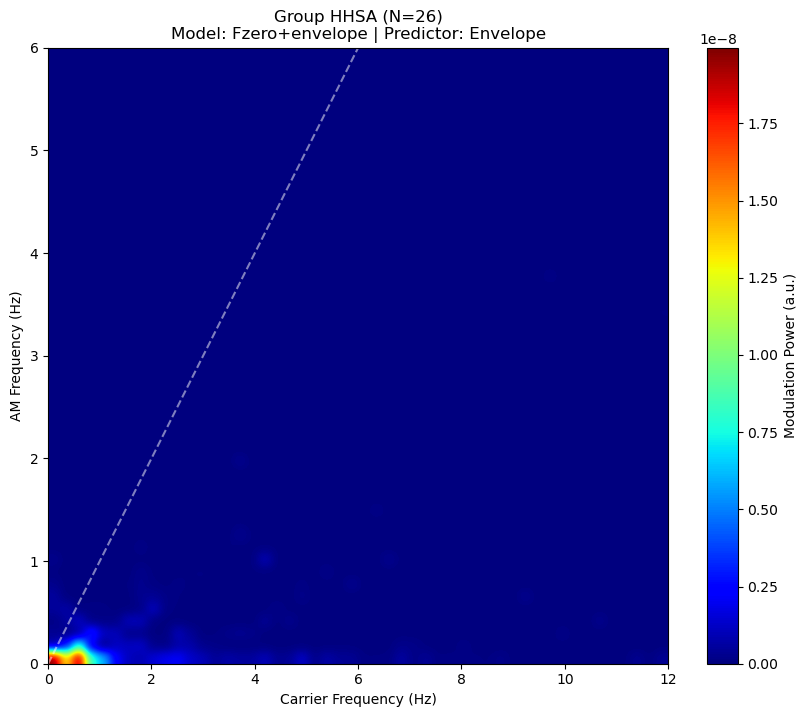

Success!


In [59]:
import numpy as np
import matplotlib.pyplot as plt
import eelbrain
from pathlib import Path
import re
import emd  # Ensure you ran: pip install EMD-signal
from scipy.signal import hilbert

# ==========================================
# 1. CORE ANALYSIS FUNCTIONS
# ==========================================
def get_inst_freq_amp(signal, fs):
    """
    Calculates instantaneous amplitude and frequency using Hilbert Transform.
    """
    analytic_signal = hilbert(signal)
    amplitude = np.abs(analytic_signal)
    instantaneous_phase = np.unwrap(np.angle(analytic_signal))
    
    # Derivative of phase for frequency
    inst_freq = np.diff(instantaneous_phase) / (2.0 * np.pi) * fs
    # Pad last point to match length
    inst_freq = np.append(inst_freq, inst_freq[-1])
    
    return amplitude, inst_freq

def run_hhsa(signal, fs):
    """
    Performs Two-Layer EMD with Mirror Padding for short signals.
    """
    if signal.ndim > 1: signal = signal.flatten()
    
    n_samples = len(signal)
    
    # Safety Check for empty/tiny signals
    if n_samples < 10: return None

    # --- A. MIRROR PADDING (Crucial for 114-point TRFs) ---
    # We reflect the signal to make it 3x longer so EMD works
    pad_width = n_samples
    padded_signal = np.pad(signal, pad_width, mode='reflect')
    
    # --- B. LAYER 1: CARRIER DECOMPOSITION ---
    try:
        # Use emd.sift.sift (Quinn library)
        # max_imfs=5 is enough for a simple TRF response
        imfs_layer1 = emd.sift.sift(padded_signal, max_imfs=5)
        imfs_layer1 = imfs_layer1.T  # Transpose to (N_IMFs, N_Time)
    except Exception:
        return None
        
    holo_points = []
    
    for imf_c in imfs_layer1:
        # Un-pad: Extract the middle 'real' part
        imf_c_real = imf_c[pad_width : pad_width + n_samples]
        
        # Get Carrier Frequency & Envelope
        env_c, freq_c = get_inst_freq_amp(imf_c_real, fs)
        
        # Skip flat/empty IMFs
        if np.sum(np.abs(env_c)) < 1e-10: continue

        # --- C. LAYER 2: AM DECOMPOSITION ---
        # Pad the envelope before sifting
        padded_env = np.pad(env_c, pad_width, mode='reflect')
        
        try:
            imfs_layer2 = emd.sift.sift(padded_env, max_imfs=5)
            imfs_layer2 = imfs_layer2.T
        except:
            continue
            
        for imf_am in imfs_layer2:
            # Un-pad AM result
            imf_am_real = imf_am[pad_width : pad_width + n_samples]
            
            _, freq_am = get_inst_freq_amp(imf_am_real, fs)
            power_am = imf_am_real**2
            
            # Filter for valid graph range
            mask = (freq_c > 0) & (freq_c < fs/2) & (freq_am > 0) & (freq_am < fs/2)
            idx = np.where(mask)[0]
            
            if len(idx) > 0:
                # Store [Carrier_Freq, AM_Freq, Power]
                points = np.vstack((freq_c[idx], freq_am[idx], power_am[idx])).T
                holo_points.append(points)
                
    if not holo_points: return None
    return np.vstack(holo_points)

# ==========================================
# 2. EXPERIMENT CONFIGURATION
# ==========================================
DATA_ROOT = Path("/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results")
EEG_DIR = DATA_ROOT / 'EEG_ESLs' / 'Alice_ESL_ICAed_fif'
TRF_DIR = DATA_ROOT / 'TRFs_ESLs'

# Extract Subjects
ESL_SUBJECTS = [path.name for path in EEG_DIR.iterdir() if re.match(r'n_2_S\d*', path.name)]
print(f"Found {len(ESL_SUBJECTS)} subjects.")

# Settings
TARGET_MODEL = 'Fzero+envelope'
LIMIT_CARRIER = 12  # Hz
LIMIT_AM = 6       # Hz
NBINS = 50

group_spectrum_sum = None
n_subjects_processed = 0

# ==========================================
# 3. MAIN LOOP
# ==========================================
print(f"Starting Group HHSA on Model: {TARGET_MODEL}")

for subject in ESL_SUBJECTS:
    subject_id_short = subject[4:8] # 'S010'
    file_path = TRF_DIR / subject_id_short / f'{subject_id_short} {TARGET_MODEL}.pickle'
    
    if not file_path.exists():
        continue

    try:
        # --- LOAD DATA ---
        trf_obj = eelbrain.load.unpickle(file_path)
        
        # Handle h vs h_scaled
        if hasattr(trf_obj, 'h_scaled'):
            data_ndvar = trf_obj.h_scaled
        else:
            data_ndvar = trf_obj.h

        # Handle Tuple (Partitioned Data)
        if isinstance(data_ndvar, tuple):
            data_ndvar = data_ndvar[0]

        # --- EXTRACT PREDICTOR ---
        trf_final = None
        
        # Strategy 1: Try name 'envelope'
        try:
            trf_final = data_ndvar['envelope']
        except:
            # Strategy 2: Try Index
            # If dims are [predictor, time], we grab the 2nd predictor (index 1)
            # Assuming the order is [F0, Envelope]
            dims = data_ndvar.dimnames
            non_time_dims = [d for d in dims if d != 'time' and d != 'sensor']
            
            if len(non_time_dims) > 0:
                dim_name = non_time_dims[0]
                # Index 1 = Envelope. Change to 0 if you want F0.
                trf_final = data_ndvar.sub(**{dim_name: 1}) 
            else:
                trf_final = data_ndvar

        # Average Sensors
        if 'sensor' in trf_final.dimnames:
            trf_final = trf_final.mean('sensor')
            
        trf_vector = trf_final.x
        fs = 1.0 / trf_final.time.tstep
        
        # --- RUN HHSA ---
        # print(f"  Processing {subject_id_short}...")
        holo_data = run_hhsa(trf_vector, fs)
        
        if holo_data is None: 
            continue
            
        # --- DEBUG PRINT ---
        # Print the average frequencies found for this subject
        avg_fc = np.mean(holo_data[:, 0])
        avg_fam = np.mean(holo_data[:, 1])
        print(f"  Subject {subject_id_short}: Avg Carrier={avg_fc:.2f}Hz, Avg AM={avg_fam:.2f}Hz")
        # -------------------
        

        # --- BIN RESULTS ---
        fc = holo_data[:, 0]
        fam = holo_data[:, 1]
        power = holo_data[:, 2]
        
        H_subj, xedges, yedges = np.histogram2d(fc, fam, bins=NBINS, weights=power,
                                           range=[[0, LIMIT_CARRIER], [0, LIMIT_AM]])
        
        if group_spectrum_sum is None:
            group_spectrum_sum = H_subj
        else:
            group_spectrum_sum += H_subj
            
        n_subjects_processed += 1
        
    except Exception as e:
        print(f"  [Error] Failed on {subject_id_short}: {e}")
        continue

# ==========================================
# 4. PLOT FINAL RESULT
# ==========================================
if n_subjects_processed > 0:
    group_avg_spectrum = group_spectrum_sum / n_subjects_processed
    
    plt.figure(figsize=(10, 8))
    # Note: .T is used because imshow expects [rows, cols] = [y, x]
    plt.imshow(group_avg_spectrum.T, origin='lower', cmap='jet', aspect='auto',
               extent=[0, LIMIT_CARRIER, 0, LIMIT_AM], interpolation='gaussian')
    
    plt.colorbar(label='Modulation Power (a.u.)')
    plt.xlabel('Carrier Frequency (Hz)')
    plt.ylabel('AM Frequency (Hz)')
    plt.title(f'Group HHSA (N={n_subjects_processed})\nModel: {TARGET_MODEL} | Predictor: Envelope')
    
    # Diagonal line (1:1 coupling)
    plt.plot([0, LIMIT_AM], [0, LIMIT_AM], 'w--', alpha=0.5)
    
    plt.show()
    print("Success!")
else:
    print("No subjects processed. Please check if pickle files contain the expected data structure.")